# Tracks from the PV

This was made in trying to understand the tracks that come from our derivation are like.

* There seem to be only a small number of tracks associated with the PV
* When following links from the `PrimaryVertex` `Vertex`, any of the `ElementLinks` are not valid.

Below is an attempt to characterize some of what we see what might be happening with the derivation.

* 2024-04-17 - Use new file from Ana with no track filtering.
* 2024-04-23 - Understand the track cuts used in the original training (see the end of this notebook), look at old EXOT15 samples, and build a recommendation.
* 2024-05-07 - More careful study of tracks near jets (as opposed to all tracks everywhere)

In [1]:
from calratio_training_data import fetch_training_data, build_preselection, run_query
import hist
from hist import Hist
import mplhep
import matplotlib.pyplot as plt
import awkward as ak

## Input

We are using a local file provided by Ana `DAOD_LLP1.outputLLP1_mc23_527565_NoLeadingJetsTracksAllPt_09042025.pool.root` - found in [MatterMost messages](https://mattermost.web.cern.ch/atlas-ueh/pl/mcg4akw3ej838xg8y94hy7ra4y). Compared to earlier versions (see 001) this has track filters turned off.

In [2]:
# Assume we are in the local directory of the notebook
ds_name = (
    "../DAOD_LLP1.outputLLP1_mc23_527565_NoLeadingJetsTracksAllPt_09042025.pool.root"
)

full_data = fetch_training_data(ds_name)

Lets get the numbers of tracks that are not valid as well as some basic info about the inner detector tracks.

* Note that we use `isValid`, which is on `ElementLink` to look for bad tracks.
* The `pv_tracks` item looks at only `ElementLink`s that have `isValid` as true (see the `training_query.py` for source if you are curious).

In [3]:
preselection = build_preselection()

extra_info_query = preselection.Select(lambda e: {
    'bad_pv_tracks': len([t for t in e.vertices.First().trackParticleLinks() if not t.isValid()]),
    'good_pv_tracks': len(e.pv_tracks),  # type: ignore
    'all_track_pt': [t.pt()/1000.0 for t in e.all_tracks],
    'all_track_eta': [t.eta() for t in e.all_tracks],
    'all_track_phi': [t.phi() for t in e.all_tracks],
    })

extra_info = run_query(ds_name, extra_info_query)

## Plots

Don't know what is really going on, but we can take a quick look at the data. First, the number of tracks that are good and bad.

In [4]:
track_axis = hist.axis.Regular(100, 0, 99, name="n Tracks")
h_good_tracks = Hist(track_axis, label="Good Tracks").fill(extra_info.good_pv_tracks)
h_bad_tracks = Hist(track_axis, label="Bad Tracks").fill(extra_info.bad_pv_tracks)

Look at the number of good and bad tracks per PV - clearly we have more bad tracks than good ones!

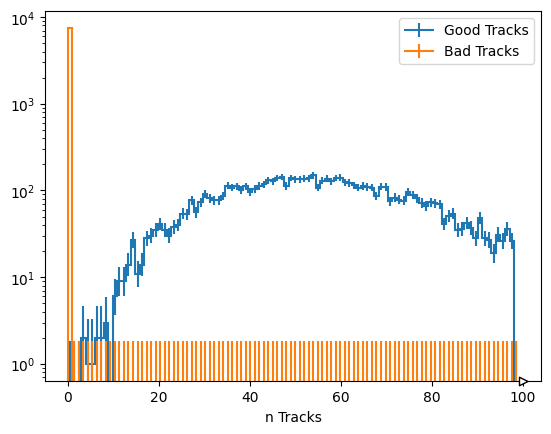

In [5]:
mplhep.histplot(h_good_tracks, label="Good Tracks")
mplhep.histplot(h_bad_tracks, label="Bad Tracks")
plt.yscale('log')
plt.legend()
plt.show()

Some basic track distributions...

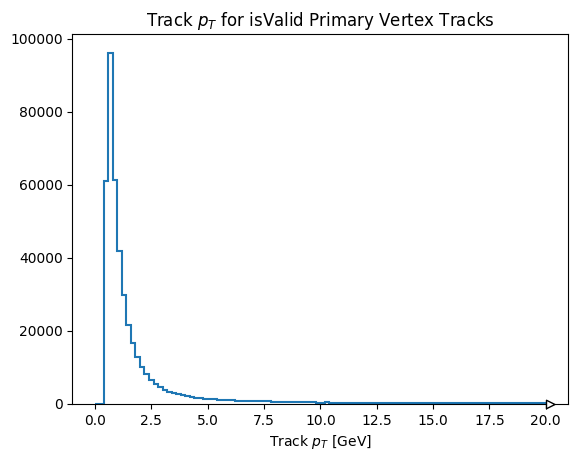

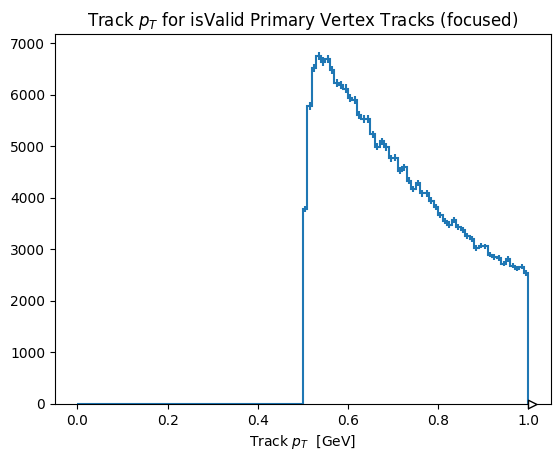

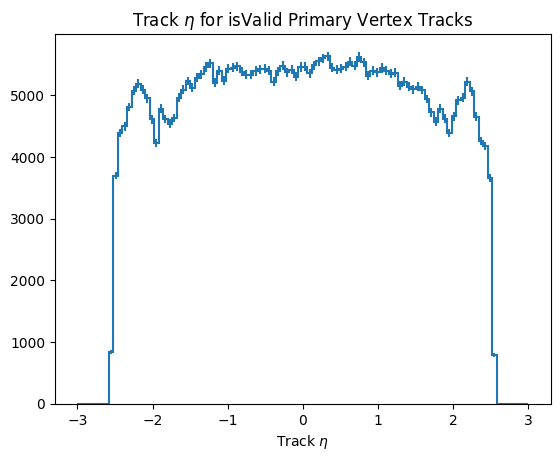

In [6]:
t_pt = Hist(hist.axis.Regular(100, 0.0, 20.0), label="Track pT", name="track pT").fill(
    ak.flatten(full_data.track_pT)
)
t_pt_close = Hist(hist.axis.Regular(100, 0.0, 1.0), label="Track pT", name="track pT").fill(
    ak.flatten(full_data.track_pT)
)
t_eta = Hist(
    hist.axis.Regular(100, -3.0, 3.0), label="Track eta", name="track eta"
).fill(ak.flatten(full_data.track_eta))
mplhep.histplot(t_pt)
plt.xlabel('Track $p_T$ [GeV]')
plt.title("Track $p_T$ for isValid Primary Vertex Tracks")
plt.show()
mplhep.histplot(t_pt_close)
plt.xlabel("Track $p_T$  [GeV]")
plt.title("Track $p_T$ for isValid Primary Vertex Tracks (focused)")
plt.show()
mplhep.histplot(t_eta)
plt.xlabel(r'Track $\eta$')
plt.title(r"Track $\eta$ for isValid Primary Vertex Tracks")
plt.show()

Lets look at the inner detector tracks next, and compare them to what we see in the PV tracks.

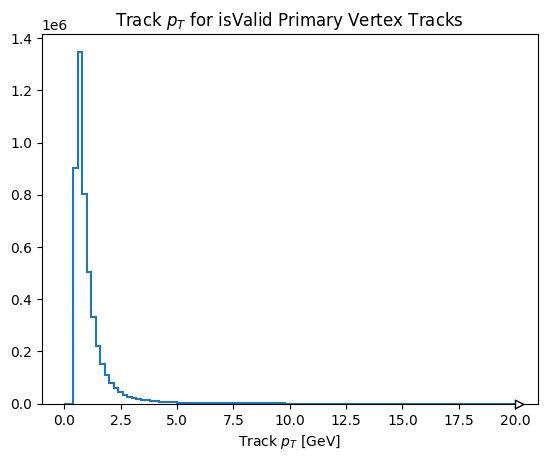

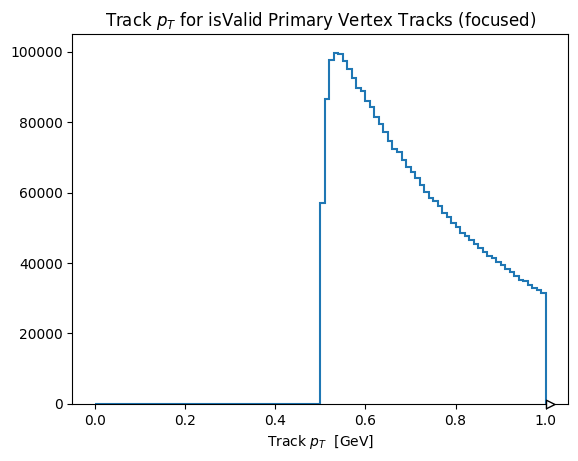

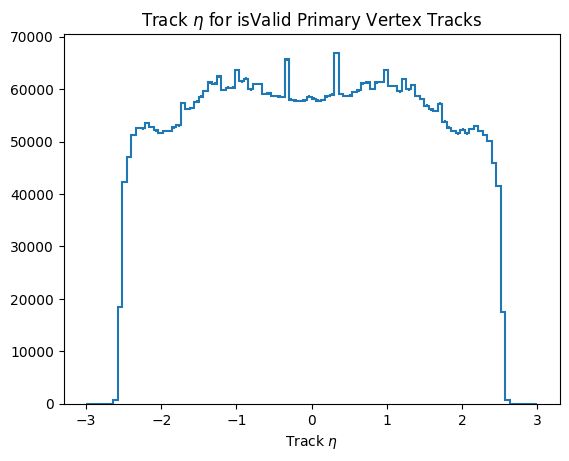

In [7]:
all_t_pt = Hist(hist.axis.Regular(100, 0.0, 20.0), label="Track pT", name="track pT").fill(
    ak.flatten(extra_info.all_track_pt)
)
all_t_pt_close = Hist(
    hist.axis.Regular(100, 0.0, 1.0), label="Track pT", name="track pT"
).fill(ak.flatten(extra_info.all_track_pt))
all_t_eta = Hist(
    hist.axis.Regular(100, -3.0, 3.0), label="Track eta", name="track eta"
).fill(ak.flatten(extra_info.all_track_eta))
mplhep.histplot(all_t_pt)
plt.xlabel("Track $p_T$ [GeV]")
plt.title("Track $p_T$ for isValid Primary Vertex Tracks")
plt.show()
mplhep.histplot(all_t_pt_close)
plt.xlabel("Track $p_T$  [GeV]")
plt.title("Track $p_T$ for isValid Primary Vertex Tracks (focused)")
plt.show()
mplhep.histplot(all_t_eta)
plt.xlabel(r"Track $\eta$")
plt.title(r"Track $\eta$ for isValid Primary Vertex Tracks")
plt.show()

And compare the shapes...

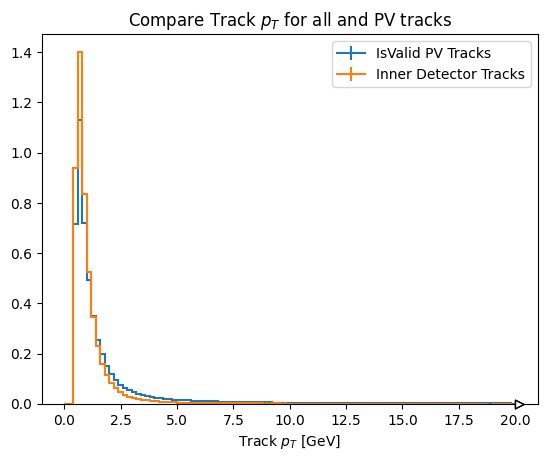

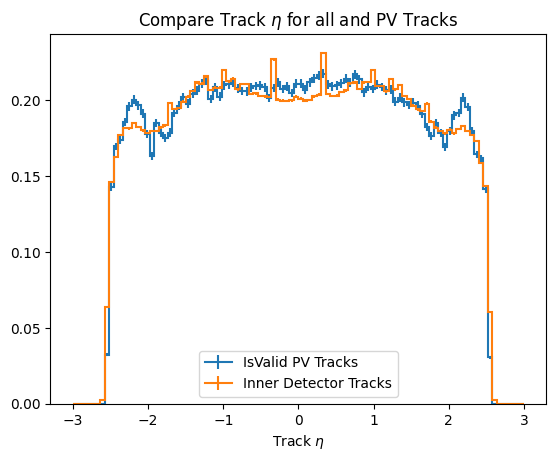

In [8]:
mplhep.histplot(t_pt, label="IsValid PV Tracks", density=True)
mplhep.histplot(all_t_pt, label="Inner Detector Tracks", density=True)
plt.xlabel("Track $p_T$ [GeV]")
plt.title("Compare Track $p_T$ for all and PV tracks")
plt.legend()
plt.show()

mplhep.histplot(t_eta, label="IsValid PV Tracks", density=True)
mplhep.histplot(all_t_eta, label="Inner Detector Tracks", density=True)
plt.xlabel(r"Track $\eta$")
plt.title(r"Compare Track $\eta$ for all and PV Tracks")
plt.legend()
plt.show()

## Original Training Cuts

Doing some archival digging to figure out what the original training cuts here.

1. Track thinning was added in October of 2020 by Paolo Sabatini. Prior to that there were no tracking cuts at all.
   * Only tracks with $\Delta R < 0.2$ from a jet axis and $p_T > 40$ GeV are kept.
   * A [custom tool](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/PhysicsAnalysis/DerivationFramework/DerivationFrameworkExotics/DerivationFrameworkExotics/SkimmingToolEXOT15.h?ref_type=heads) was used to do this specific thinning.
1. Prior to that, no track thinning was being done.

Tracks are used in two places in our prior analysis:

a. In the NN training - there all tracks in the InnerDetector track collection are used, with the cuts above.
b. In the BDT - there only tracks from the PV are used.

See [issue](https://github.com/gordonwatts/sx_training_fetch/issues/59) for some code references.

## Looking at prior training data plots

Lets look at the training data the Felix has been using (and the most recent skims that Alex has looked at):

In [10]:
import pandas

training_file = "https://cernbox.cern.ch/remote.php/dav/public-files/r0GQeSVMuu0mDKX/processed_output_controlRegion_corrected.pkl"
training_data = pandas.read_pickle(training_file)

In [13]:
print([name for name in training_data.columns if "track" in name])

['track_pT_0', 'track_eta_0', 'track_phi_0', 'track_vertex_nParticles_0', 'track_d0_0', 'track_z0_0', 'track_chiSquared_0', 'track_PixelShared_0', 'track_SCTShared_0', 'track_PixelHoles_0', 'track_SCTHoles_0', 'track_PixelHits_0', 'track_SCTHits_0', 'track_pT_1', 'track_eta_1', 'track_phi_1', 'track_vertex_nParticles_1', 'track_d0_1', 'track_z0_1', 'track_chiSquared_1', 'track_PixelShared_1', 'track_SCTShared_1', 'track_PixelHoles_1', 'track_SCTHoles_1', 'track_PixelHits_1', 'track_SCTHits_1', 'track_pT_2', 'track_eta_2', 'track_phi_2', 'track_vertex_nParticles_2', 'track_d0_2', 'track_z0_2', 'track_chiSquared_2', 'track_PixelShared_2', 'track_SCTShared_2', 'track_PixelHoles_2', 'track_SCTHoles_2', 'track_PixelHits_2', 'track_SCTHits_2', 'track_pT_3', 'track_eta_3', 'track_phi_3', 'track_vertex_nParticles_3', 'track_d0_3', 'track_z0_3', 'track_chiSquared_3', 'track_PixelShared_3', 'track_SCTShared_3', 'track_PixelHoles_3', 'track_SCTHoles_3', 'track_PixelHits_3', 'track_SCTHits_3', 'tr

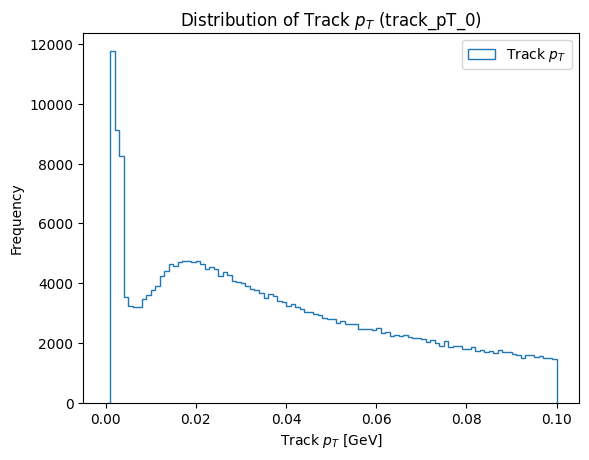

In [22]:
plt.hist(training_data['track_pT_0'], bins=100, range=(0, 0.1), histtype='step', label='Track $p_T$')
plt.xlabel('Track $p_T$ [GeV]')
plt.ylabel('Frequency')
plt.title('Distribution of Track $p_T$ (track_pT_0)')
plt.legend()
plt.show()

Ops - right - they have already been normalized!

Our Run 2 `EXOT15` datasets are still around - lets look at once of those and see what the tracks look like.

* We only need one file's worth of tracks!!

In [24]:
calratio_x_dsname = "mc16_13TeV:mc16_13TeV.311425.MGPy8EG_A14NNPDF23_NNPDF31ME_HSS_LLP_mH1000_mS50.deriv.DAOD_EXOT15.e7357_e5984_s3234_r10201_r10210_p4696_tid26710934_00"

# Because we aren't running calibrations for tracks, I hope R25 code works on this!
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE

query = FuncADLQueryPHYSLITE().SelectMany(
    lambda e: e.TrackParticles("InDetTrackParticles").Select(
        lambda t: {"pt": t.pt(), "eta": t.eta()}
    )
)

from servicex import ServiceXSpec, Sample, dataset, deliver
import uproot
import awkward as ak

ds = dataset.Rucio(calratio_x_dsname, num_files=1)
spec = ServiceXSpec(
    Sample=[
        Sample(
            Name="HSS_1000_50",
            Dataset=ds,
            Query=query,  # type: ignore
            Codegen="atlasr22",
        ),
    ],
)

from calratio_training_data.training_query import run_query

result = deliver(spec)['HSS_1000_50']
data = ak.concatenate(list(uproot.iterate(result, library="ak")))

Output()

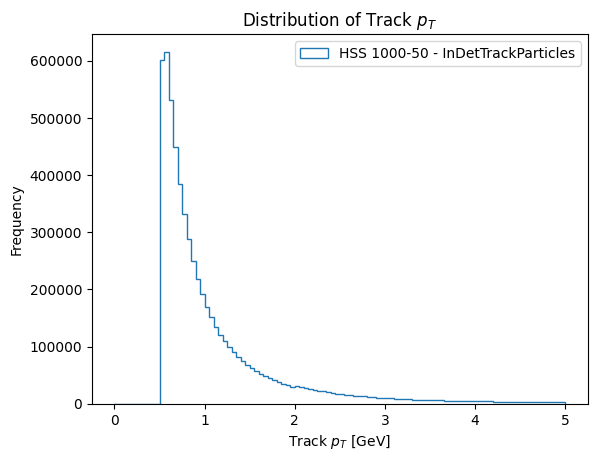

In [27]:
import matplotlib.pyplot as plt

plt.hist(
    ak.to_numpy(data.pt / 1000),
    bins=100,
    range=(0, 5),
    histtype="step",
    label="HSS 1000-50 - InDetTrackParticles",
)
plt.xlabel('Track $p_T$ [GeV]')
plt.ylabel('Frequency')
plt.title('Distribution of Track $p_T$')
plt.legend()
plt.show()

So - cut at 0.5 GeV, and then something (?) at 2 GeV that is barely noticeable.

__Recommendation__

* Track $p_T$ cut at 0.5 GeV
* Implement the $\Delta R < 0.2$ cut and keep only tracks inside that.

A future study to determine what tracks are "interesting" for this.

## Non-training Tracks

The above recommendation works for the training tracks. The training tracks look at [all tracks](https://gitlab.cern.ch/atlas-phys-exotics-llp-mscrid/fullrun2analysis/DiVertAnalysisR21/-/blob/master/DiVertAnalysis/Root/RegionVarCalculator_calRatio.cxx#L289) with $\Delta R < 0.2$ ([as applied here](https://gitlab.cern.ch/atlas-phys-exotics-llp-mscrid/fullrun2analysis/DiVertAnalysisR21/-/blob/master/DiVertAnalysis/Root/RegionVarCalculator_calRatio.cxx#L551)). In the current LLP1 derivation, you can see there is [a filter that keeps all those tracks near a jet](https://gitlab.cern.ch/atlas/athena/-/blob/main/PhysicsAnalysis/DerivationFramework/DerivationFrameworkLLP/python/LLP1.py#L625). The $\Delta R$ cut for track-association [tool header](https://gitlab.cern.ch/atlas/athena/-/blob/main/PhysicsAnalysis/DerivationFramework/DerivationFrameworkInDet/DerivationFrameworkInDet/JetTrackParticleThinning.h) and the [source](importedTrackParticles). So it gets all tracks associated with the jet.

* Question: what selection cuts are made of the tracks? Is it juts $\Delta R$ or do they do PV matching?

What about the non-training tracks? These were used in previous versions of the analysis for the BDT afterburner at the analysis level. The [code can be found here](https://gitlab.cern.ch/atlas-phys-exotics-llp-mscrid/fullrun2analysis/DiVertAnalysisR21/-/blob/master/DiVertAnalysis/Root/RegionVarCalculator_calRatio.cxx#L551).

* Looks at all tracks from the PV that [pass the loose track selection](https://gitlab.cern.ch/atlas-phys-exotics-llp-mscrid/fullrun2analysis/DiVertAnalysisR21/-/blob/master/DiVertAnalysis/Root/RegionVarCalculator_calRatio.cxx#L801).
* All tracks with $p_T > 500$ and $\Delta R < 0.2$ are $p_T$ summed. Super confusing how the logic works!
* The $\Delta R$ of the track closest jet with $p_T > 2 GeV$ is saved.

### Conclusion

a. That only tracks within $\Delta R < 0.2$ are used, despite the confusing code in our derivation
a. The old code grabbed all the tracks for training, and then does the association. The current LLP1 derivation grabs tracks associated with the jet.

Todo:

* Check that the tracks associated with the jet are also all the tracks that we would use for tracking.
* Double check the $\Delta R$ that is actually used in the skimming

### Tracks in the Jet's Environment

We need to look at the # of tracks per jet and the $p_T$ distribution of tracks that are near a jet. We'll need to look at this for both the samples with no track cuts and one with track cuts.

In [2]:
def fetch_jets_and_tracks(ds_name: str):
    'Return a list of jets and the nearby associated tracks'
    preselection = build_preselection()

    extra_info_query = preselection.Select(
        lambda e: {
            "track_pt": [t.pt() / 1000.0 for t in e.all_tracks],
            "track_eta": [t.eta() for t in e.all_tracks],
            "track_phi": [t.phi() for t in e.all_tracks],
            "jet_pt": [j.pt() / 1000.0 for j in e.jets],
            "jet_eta": [j.eta() for j in e.jets],
            "jet_phi": [j.phi() for j in e.jets],
        }
    )
    extra_info = run_query(ds_name, extra_info_query)
    return extra_info

skimmed_data = fetch_jets_and_tracks(
    "../DAOD_LLP1.outputLLP1_mc23_537565_trigger.pool.root"
)
all_tracks_data = fetch_jets_and_tracks(
    "../DAOD_LLP1.outputLLP1_mc23_527565_NoLeadingJetsTracksAllPt_09042025.pool.root"
)

In [3]:
def make_jet_dataset(data: ak.Array):
    import vector

    vector.register_awkward()

    jets = ak.zip(
        {
            "pt": data.jet_pt,
            "eta": data.jet_eta,
            "phi": data.jet_phi,
        },
        with_name="Momentum3D",
    )
    tracks = ak.zip(
        {
            "eta": data.track_eta,
            "phi": data.track_phi,
            "pt": data.track_pt,
        },
        with_name="Momentum3D",
    )

    # Compute DeltaR between each jet and all tracks in the same event
    jet_track_pairs = ak.cartesian({"jet": jets, "track": tracks}, axis=1, nested=True)
    delta_r = jet_track_pairs.jet.deltaR(jet_track_pairs.track)

    jet_tracks = ak.zip(
        {
            "jets": ak.zip(
                {
                    "pt": jets.pt,
                    "eta": jets.eta,
                    "phi": jets.phi,
                    "tracks": ak.zip(
                        {
                            "pt": jet_track_pairs.track[delta_r < 0.4].pt,
                            "eta": jet_track_pairs.track[delta_r < 0.4].eta,
                            "phi": jet_track_pairs.track[delta_r < 0.4].phi,
                            "dr": delta_r[delta_r < 0.4],
                        },
                        with_name="Momentum3D",
                    ),
                },
                with_name="Momentum3D",
            ),
        }
    )

    return jet_tracks

skimmed_jt = make_jet_dataset(skimmed_data)
all_tracks_jt = make_jet_dataset(all_tracks_data)

Lets check that the number of tracks near jets is similar (or not)

In [4]:
len(ak.flatten(all_tracks_jt.jets.tracks.dr)), len(ak.flatten(skimmed_jt.jets.tracks.dr))

(17595, 17595)

That is promising - means that the way it associates tracks with the jet doesn't depend on the PV. But just to be sure - lets look at the source from running against the files - make sure that they really are different!

In [5]:
len(ak.flatten(skimmed_data.track_pt)), len(ak.flatten(all_tracks_data.track_pt))

(1105068, 4822439)

And as a last check, lets make sure that the DR distributions look the same!

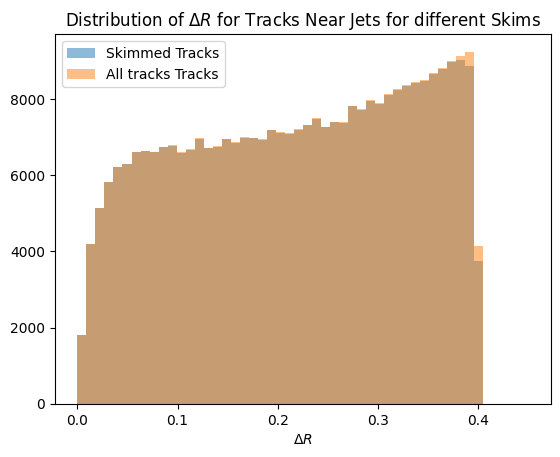

In [14]:
# Flatten the dr arrays for both datasets
skimmed_dr = ak.flatten(skimmed_jt.jets.tracks.dr, axis=None)
all_tracks_dr = ak.flatten(all_tracks_jt.jets.tracks.dr, axis=None)

plt.hist(skimmed_dr, bins=50, range=(0, 0.45), label="Skimmed Tracks", alpha=0.5)
plt.hist(all_tracks_dr, bins=50, range=(0, 0.45), label="All tracks Tracks", alpha=0.5)

plt.xlabel(r"$\Delta R$")
plt.title(r"Distribution of $\Delta R$ for Tracks Near Jets for different Skims")
plt.legend()
plt.show()